<a href="https://colab.research.google.com/github/raghavadevarajeurs/DeepLearning/blob/main/Assignment6/CNN_ImageClassifier_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#!pip install pytorch-lightning --quiet
#import pytorch_lightning as pl

     |████████████████████████████████| 808kB 17.3MB/s 
     |████████████████████████████████| 829kB 50.9MB/s 
     |████████████████████████████████| 645kB 54.1MB/s 
     |████████████████████████████████| 112kB 57.6MB/s 
     |████████████████████████████████| 276kB 57.8MB/s 
     |████████████████████████████████| 1.3MB 56.0MB/s 
     |████████████████████████████████| 143kB 56.7MB/s 
     |████████████████████████████████| 296kB 56.7MB/s 


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

In [2]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


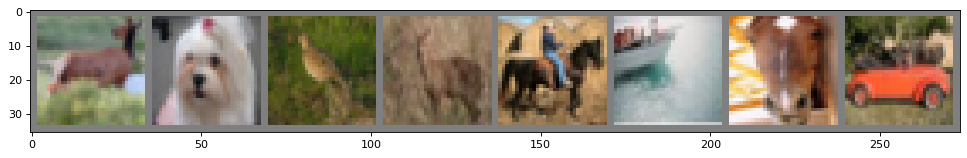

        deer          dog         bird         deer        horse         ship        horse          car


In [3]:
def imshow(img):
    plt.figure(figsize=(15, 10), dpi = 80)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%12s' % classes[labels[j]] for j in range(batch_size)))

In [4]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [5]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(10):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

[1,  2000] loss: 2.184
[1,  4000] loss: 1.793
[1,  6000] loss: 1.585
[2,  2000] loss: 1.475
[2,  4000] loss: 1.428
[2,  6000] loss: 1.388
[3,  2000] loss: 1.306
[3,  4000] loss: 1.291
[3,  6000] loss: 1.267
[4,  2000] loss: 1.198
[4,  4000] loss: 1.168
[4,  6000] loss: 1.171
[5,  2000] loss: 1.098
[5,  4000] loss: 1.097
[5,  6000] loss: 1.090
[6,  2000] loss: 1.018
[6,  4000] loss: 1.031
[6,  6000] loss: 1.032
[7,  2000] loss: 0.949
[7,  4000] loss: 0.976
[7,  6000] loss: 0.981
[8,  2000] loss: 0.896
[8,  4000] loss: 0.931
[8,  6000] loss: 0.926
[9,  2000] loss: 0.856
[9,  4000] loss: 0.877
[9,  6000] loss: 0.902
[10,  2000] loss: 0.815
[10,  4000] loss: 0.848
[10,  6000] loss: 0.844


In [7]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 63 %
Accuracy of   car : 74 %
Accuracy of  bird : 59 %
Accuracy of   cat : 53 %
Accuracy of  deer : 55 %
Accuracy of   dog : 47 %
Accuracy of  frog : 69 %
Accuracy of horse : 73 %
Accuracy of  ship : 73 %
Accuracy of truck : 69 %


In [12]:
class pyLightningModel(pl.LightningModule):

      def __init__(self):
        super(pyLightningModel, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,28,kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(28,10,kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))
        self.dropout1=torch.nn.Dropout(0.25)
        self.fc1=torch.nn.Linear(250,18)
        self.dropout2=torch.nn.Dropout(0.08)
        self.fc2=torch.nn.Linear(18,10)
        
      #preparing the data from MNIST dataset for training
      def prepare_data(self):
          MNIST(os.getcwd(), train=True, download =True)
          MNIST(os.getcwd(), train=False, download =True)
      
      def train_dataloader(self):
          mnist_train=MNIST(os.getcwd(), train=True, download =False,transform=transforms.ToTensor())
          self.train_set, self.val_set= random_split(mnist_train,[55000,5000])
          return DataLoader(self.train_set,batch_size=128)
          
      def val_dataloader(self):
          return DataLoader(self.val_set, batch_size=128)

      def test_dataloader(self):
          return DataLoader(MNIST(os.getcwd(), train=False, download=False, transform=transforms.ToTensor()), batch_size=128)

      def forward(self,x):
          x=self.layer1(x)
          x=self.layer2(x)
          x=self.dropout1(x)
          x=torch.relu(self.fc1(x.view(x.size(0), -1)))
          x=F.leaky_relu(self.dropout2(x))
          return F.softmax(self.fc2(x))


      def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

      def training_step(self,batch,batch_idx):
          x,labels=batch
          pred=self.forward(x)
          loss = F.nll_loss(pred, labels)
          logs={"train_loss": loss}
          output={
              "loss": loss,
              "log": logs
          }
          return output

In [13]:
plTrainer=pl.Trainer(gpus=1, max_epochs=10)
model=pyLightningModel()
plTrainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Failed to download (trying next):
HTTP Error 503: Service Unavailable



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)



Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done!



  | Name     | Type       | Params
----------------------------------------
0 | layer1   | Sequential | 728   
1 | layer2   | Sequential | 1.1 K 
2 | dropout1 | Dropout    | 0     
3 | fc1      | Linear     | 4.5 K 
4 | dropout2 | Dropout    | 0     
5 | fc2      | Linear     | 190   
----------------------------------------
6.6 K     Trainable params
0         Non-trainable params
6.6 K     Total params
0.026     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
